# Tutorial: Solving and Visualizing a Dial-A-Ride Problem (DARP) with Python

This tutorial demonstrates how to solve a *Dial-A-Ride Problem* (DARP) using a custom Python package and visualize the solution.
We will cover structuring the project, loading DARP instances, building and solving MILP models, and plotting vehicle routes.

## The Problem

The *Dial-A-Ride Problem* (DARP) is a transportation and logistics challenge focusing on efficiently routing a fleet of vehicles, denoted by $k \in K$, to service passengers at designated pickup ($i \in P$) and drop-off ($j \in D$) points. The goal is to minimize the total travel cost, $c_{ijk}$, while ensuring each route starts and ends at a depot node ($o \in O$). Crucially, DARP requires adherence to users' specified earliest and latest service times, adding a layer of complexity to the scheduling process.

## Step 1: Environment Setup

To ensure smooth operation within a Jupyter Notebook, we first set up our environment:


In [1]:
import sys
sys.path.append("../")  # Adding parent directory to the path

# IPython magic commands for auto-reloading modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This setup facilitates importing modules from outside the notebook directory and auto-reloads any changed modules.

## Step 2: Project Structure and Importing Modules

The project follows a structure inspired by the [Cookiecutter Data Science](https://drivendata.github.io/cookiecutter-data-science/) standard, a widely recognized template for organizing data science projects.
This structure is designed to keep the project organized and manageable, ensuring a logical separation of data, models, solutions, and visualizations.

### Project Structure

The project has several key directories:

- **`data`**: Stores all project-related data, including raw and processed datasets.
- **`notebooks`**: Contains Jupyter notebooks, where we execute our data processing, modeling, and visualization steps. The code for solving and visualizing the DARP is primarily located here.
- **`references`**: Includes reference materials like papers and manuals relevant to the project.
- **`reports/figures`**: Used for storing generated figures and plots.
- **`reports/tables`**: Used for storing generated tables (.csv).
- **`src`**: The source code directory with various subdirectories:
  - **`data`**: Contains `parser.py`, which handles parsing and loading data.
  - **`model`**: For model definitions and data schemas (e.g., "Vehicle", "Node", "Request" classes).
  - **`solution`**: Code related to processing or interpreting solutions.
  - **`solver`**: Includes `darp.py`, the implementation of the DARP solver.
  - **`visualization`**: Code dedicated to data visualization (e.g., plot routes).

### Importing Modules

Now, let's import the required functions and classes from our `src` package:


In [2]:
from time import time
import matplotlib.pyplot as plt
from pprint import pprint

# Parser to load and parse DARP instance data
from src.data.parser import parse_instance_from_filepath

# Darp class for building and solving the DARP model
from src.solver.darp import Darp

# Function for plotting vehicle routes
from src.visualization.route import plot_vehicle_route

These imports bring in functionalities for loading DARP instances, solving them, and visualizing the results.
By organizing the code into different modules within the `src` package, we enhance the maintainability and reusability of our code, making it easier to navigate and adapt for various analyses.

## Step 3: Load and Initialize DARP Instance

We load the DARP instance, and parse it into a Pandas DataFrame for a tabular view of the instance data related to nodes.

### Instance structure

A DARP instance is as follows:

```raw
4 8 480 3 30
 0   0.000   0.000   0   0    0  480
 1  -1.198  -5.164   3   1    0 1440
 2   5.573   7.114   3   1    0 1440
 3  -6.614   0.072   3   1    0 1440
 4  -7.374  -1.107   3   1    0 1440
 5  -9.251   8.321   3   1    0 1440
 6   6.498  -6.036   3   1    0 1440
 7   0.861   6.903   3   1    0 1440
 8   3.904  -5.261   3   1    0 1440
 9   6.687   6.731   3  -1  402  417
10  -2.192  -9.210   3  -1  322  337
11  -1.061   8.752   3  -1  179  194
12   6.883   0.882   3  -1  138  153
13   5.586  -1.554   3  -1   82   97
14  -9.865   1.398   3  -1   49   64
15  -9.800   5.697   3  -1  400  415
16   1.271   1.018   3  -1  298  313
17   0.000   0.000   0   0    0  480
```

The first line `3 8 480 3 30` features, in turn:

- $|K|$: number of vehicles (`4`),
- $|P|$: number of customers (`8`),
- $T$: maximum route duration (`480`),
- $|Q|$: vehicle capacity (`3`),
- $L$: maximum ride time (`30`).

The subsequent lines comprise the columns:

- node id ($i \in N$),
- x coordinate,
- y coordinate,
- service duration at node ($d$)
- load (positive for $i \in P$, negative for $i \in D$, zero for $i=\text{depot}$),
- earliest arrival time ($e$),
- latest arrival time ($l$).

The second line `0   0.000   0.000   0   0    0  480` corresponds to the depot data.

The following $n=|P|=4$ lines feature the pickup node data:

```raw
 1  -1.198  -5.164   3   1    0 1440
 2   5.573   7.114   3   1    0 1440
 3  -6.614   0.072   3   1    0 1440
 4  -7.374  -1.107   3   1    0 1440
 5  -9.251   8.321   3   1    0 1440
 6   6.498  -6.036   3   1    0 1440
 7   0.861   6.903   3   1    0 1440
 8   3.904  -5.261   3   1    0 1440
```

The following $n=|D|=8$ lines feature the destination node data:

```raw
 9   6.687   6.731   3  -1  402  417
10  -2.192  -9.210   3  -1  322  337
11  -1.061   8.752   3  -1  179  194
12   6.883   0.882   3  -1  138  153
13   5.586  -1.554   3  -1   82   97
14  -9.865   1.398   3  -1   49   64
15  -9.800   5.697   3  -1  400  415
16   1.271   1.018   3  -1  298  313
```

The last line `33   0.000   0.000   0   0    0  480` corresponds to the destination depot data.
This node is replicated so all vehicles have to return to it.

Hence,  for example, passenger $i=1$:

- shall be picked up at node $1 \in P$ with load $q_1 = 1$,
- shall be picked up point $(x,y)=(-1.198, -5.164)$,
- shall be picked up within time window $(e_1, l_1) = (0, 1440)$,
- takes a pickup service duration $d_1=3$.

Later, passenger $1$:

- shall be delivered at node $n+i = 9$ with load $q_{9} = -1$ (i.e., $q_{9} = -q_1$),
- shall be delivered at point $(x,y)=(6.687, 6.731)$,
- shall be delivered within time window $(e_{9}, l_{9}) = (402, 417)$,
- takes a delivery service duration $d_{9}=3$.


In [3]:
# Path to the DARP instance data
instance_filepath = "../data/raw/darp_instances/darp_cordeau_2006/a4-8"

t_start = time()
instance_obj = parse_instance_from_filepath(instance_filepath)

#Loading time is measured for performance analysis
print("Time to load instance:", time() - t_start)

# The instance configuration
pprint(instance_obj.config)

Time to load instance: 0.0029990673065185547
InstanceConfig(n_vehicles=4,
               n_customers=8,
               time_horizon_min=480,
               vehicle_capacity=3,
               maximum_ride_time_min=30)


DataFrame view of the instance:


In [4]:
# Displaying the instance data as a DataFrame for verification
df_instance = instance_obj.nodeset_df
df_instance

,alias,node_type,x,y,earliest,latest,service_duration
id,,,,,,,
0,Depot,O_DEPOT,0.000,0.000,0,480,0
1,1,PU,-1.198,-5.164,0,1440,3
2,2,PU,5.573,7.114,0,1440,3
3,3,PU,-6.614,0.072,0,1440,3
4,4,PU,-7.374,-1.107,0,1440,3
5,5,PU,-9.251,8.321,0,1440,3
6,6,PU,6.498,-6.036,0,1440,3
7,7,PU,0.861,6.903,0,1440,3
8,8,PU,3.904,-5.261,0,1440,3


Spread of the nodes colored by type (pickup, dropoff, or depot):


<Axes: xlabel='x', ylabel='y'>

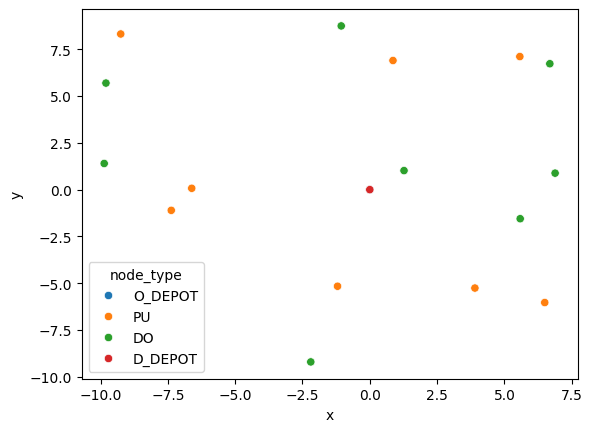

In [5]:
import seaborn as sns
sns.scatterplot(df_instance, x="x", y="y", hue="node_type")

## Step 4: Model Preparation and Building

The DARP model is initialized, and its components are set up:


In [6]:
# Initializing the DARP model
t_start = time()
model = Darp(instance_obj)
print("Time to initialize the model:", time() - t_start)

# Building the model with constraints, variables, and objective function
t_start = time()
model.build()
print("Time to build the model:", time() - t_start)

Time to initialize the model: 0.004699230194091797
Time to build the model: 0.062433481216430664


This step prepares the model with all necessary components for optimization.

## Step 5: Solve the Model

We solve the model to find optimal routes for vehicles:


In [7]:
# Solving the model to minimize costs
t_start = time()
solution_obj = model.solve()
print("Time to solve the model:", time() - t_start)

Time to solve the model: 0.509925127029419


`solution_obj` will contain the optimized vehicle routes.

## Step 6: Analyzing the Solution

We explore the solution's output.

### Solver stats

Solver output:


In [8]:
# Detailed solver-specific information
pprint(solution_obj.solver_stats)

SolutionSolver(sol_objvalue=179.99460601493135,
               sol_cputime=643,
               graph_numedges=249,
               graph_numnodes=18,
               solver_numconstrs=2496,
               solver_numvars=1172,
               solver_numiterations=551,
               solver_numnodes=1)


### Vehicle routes

#### String Representation

Vehicle routes are presented as strings featuring:

  - Vehicle id
  - `D`: Route total duration (e.g., for vehicle `4`: 466.708 - 98.245 = 368.463)
  - `Q`: Max. occupancy
  - `W`: Avg. total waiting at pickup and delivery nodes (vehicle arrived earlier than earliest time window)
  - `T`: Avg. transit time (total ride time / number of requests)

Then, routes are presented as a sequence of nodes:

  - Node id
  - `w`: Slack time (vehicle arrives at time `t`, waits `w` time units until `b`)
  - `b`: Arrival time
  - `t`: Ride delay (only at dropoff nodes)
  - `q`: Vehicle current capacity


In [9]:
# Show vehicle routes as a dictionary (key=vehicle id, value=vehicle route info)
pprint(solution_obj.vehicle_routes)

{0: 0 D:    74.2221 Q:  1 W:   322.2660 T:    48.0767   0 (w:   0.00; b:   0.00; t:   0.00; q:   0.00)   4 (w: 112.54; b: 120.00; t:   0.00; q:   1.00)  12 (w:   0.60; b: 138.00; t:  15.00; q:   0.00)   2 (w: 168.56; b: 315.92; t:   0.00; q:   1.00)  10 (w:   0.00; b: 337.00; t:  18.08; q:   0.00)   1 (w:  39.83; b: 384.00; t:   0.00; q:   1.00)   9 (w:   0.73; b: 402.00; t:  15.00; q:   0.00)  17 (w:   0.00; b: 480.00; t:   0.00; q:   0.00),
 1: 1 D:     0.0000 Q:  0 W:     0.0000 T:     0.0000   0 (w:   0.00; b:   0.00; t:   0.00; q:   0.00)  17 (w:   0.00; b: 480.00; t:   0.00; q:   0.00),
 2: 2 D:    64.1223 Q:  1 W:   220.5061 T:    90.0000   0 (w:   0.00; b:   0.00; t:   0.00; q:   0.00)   6 (w:   7.13; b:  16.00; t:   0.00; q:   1.00)  14 (w:  12.03; b:  49.00; t:  30.00; q:   0.00)   5 (w:   2.23; b:  61.18; t:   0.00; q:   1.00)  13 (w:  12.18; b:  94.18; t:  30.00; q:   0.00)   8 (w: 163.75; b: 265.00; t:   0.00; q:   1.00)  16 (w:  23.19; b: 298.00; t:  30.00; q:   0.00)  17

#### Data Frame

In the following, we present the routes as a Pandas DataFrame.


In [10]:
# Notice that a "dist" function is passed to calculate the distances
# between subsequent nodes. This distance function belongs to the DARP model.
df = solution_obj.route_df(fn_dist=model.dist)
df.to_csv("../reports/tables/routes_a4-8.csv")
df

,vehicle_id,vehicle_load,id,alias,node_type,x,y,distance_previous,waiting,earliest,arrival,latest,service_duration,departure
0,0,0,0,Depot,O_DEPOT,0.00,0.00,0.00,0.00,0,0.00,480,0,0.00
1,0,1,4,4,PU,-7.37,-1.11,7.46,112.54,0,120.00,1440,3,123.00
2,0,0,12,4*,DO,6.88,0.88,14.40,0.60,138,138.00,153,3,141.00
3,0,1,2,2,PU,5.57,7.11,6.37,168.56,0,315.92,1440,3,318.92
4,0,0,10,2*,DO,-2.19,-9.21,18.08,0.00,322,337.00,337,3,340.00
5,0,1,1,1,PU,-1.20,-5.16,4.17,39.83,0,384.00,1440,3,387.00
6,0,0,9,1*,DO,6.69,6.73,14.27,0.73,402,402.00,417,3,405.00
7,0,0,17,Depot,D_DEPOT,0.00,0.00,9.49,0.00,0,480.00,480,0,480.00
8,1,0,0,Depot,O_DEPOT,0.00,0.00,0.00,0.00,0,0.00,480,0,0.00
9,1,0,17,Depot,D_DEPOT,0.00,0.00,0.00,0.00,0,480.00,480,0,480.00


This option allows us to quickly filter each vehicle's output.
For example, if we want to see only the nodes serviced by vehicle 0:


In [11]:
df_0 = df[df["vehicle_id"]==0][["vehicle_load", "alias"]]
df_0

,vehicle_load,alias
0,0,Depot
1,1,4
2,0,4*
3,1,2
4,0,2*
5,1,1
6,0,1*
7,0,Depot


### Summary stats


In [12]:
# Summarizing the solution
pprint(solution_obj.summary)

SolutionSummary(cost=179.99460601493132,
                total_duration=1920.0,
                total_waiting=903.4574270618939,
                avg_waiting=225.86435676547347,
                total_transit=178.07673092680199,
                avg_transit=44.519182731700496)


## Step 7: Visualizing Vehicle Routes

Finally, we visualize the routes for each vehicle:


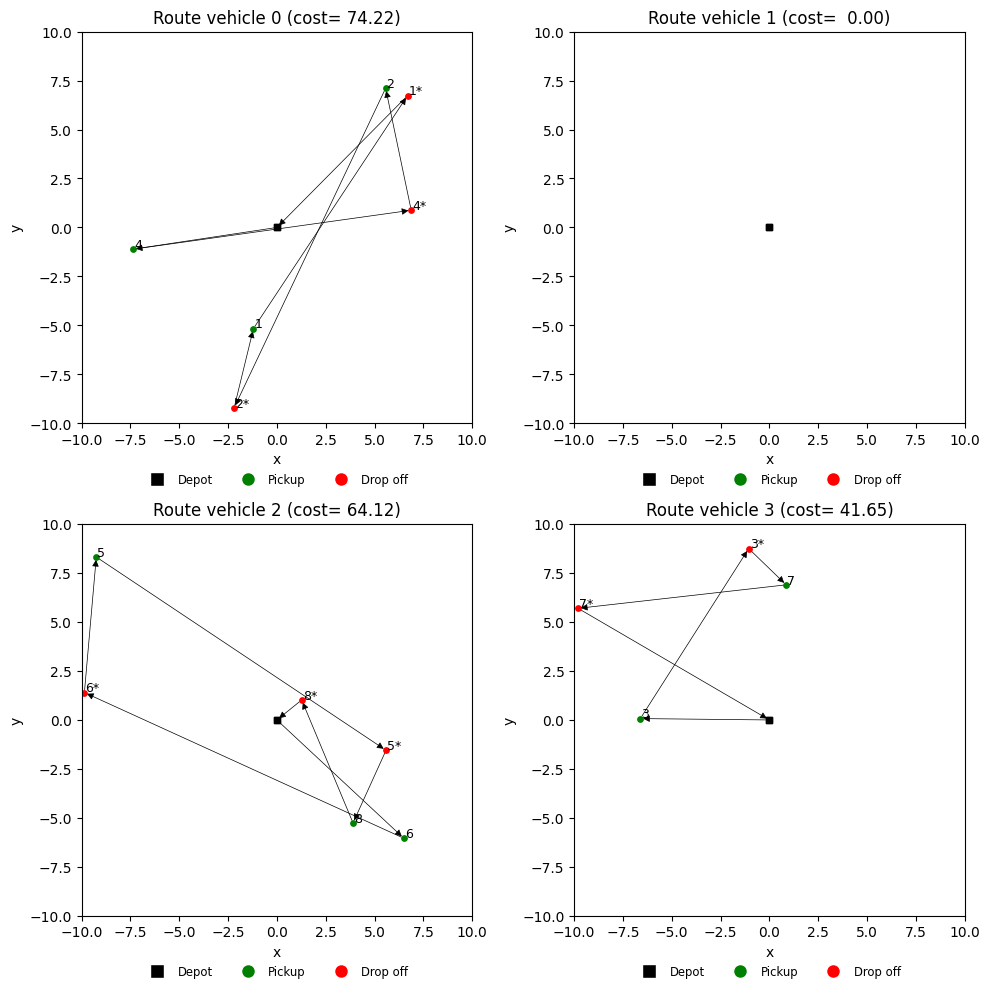

In [13]:
# Creating a 2x2 grid for plotting routes
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

# Iterating through vehicle routes for visualization
for vehicle_id, vehicle_sol in solution_obj.vehicle_routes.items():
    df_vehicle_solution = df[df["vehicle_id"] == vehicle_id].copy()
    title_plot = f"Route vehicle {vehicle_id} ({vehicle_sol.summary()})"
    plot_vehicle_route(axs[vehicle_id], df_vehicle_solution, title=title_plot)

plt.tight_layout()

# Saving the figure for reports and further analysis
plt.savefig("../reports/figures/routes_panel.svg")

Each subplot in the 2x2 grid displays a different vehicle's route, providing a comprehensive view of the solution.

## Conclusion

This tutorial illustrated how to employ a custom Python  package to solve and visualize DARP instances.
The primary emphasis of this approach is on clarity and ease of presentation, allowing us to focus on the analytical aspects of the problem while leaving the intricacies of implementation to the underlying package.

By encapsulating the more complex aspects of the code within the `src` package, we achieve a clean and intuitive interface for interacting with the DARP models.
This structure not only simplifies the workflow for users but also enhances maintainability and scalability of the codebase.
It's an illustration of how well-organized code and thoughtful abstraction can make a significant difference in data science and optimization tasks.